### Task 2 — Statistical decision making

In [44]:
# CODE: imports and settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
%matplotlib inline


####  Load the data and quick overview

In [47]:
df = pd.read_csv("task2_synthetic_production.csv")
df.head()

,ProductionDate,BatchID,Product,MachineID,OperatorID,Shift,ProductionTime_min,Temperature_C,Humidity_pct,Pressure_kPa,Speed_units_per_min,QualityScore,DefectCount,QualityLabel
0,2024-04-12,B1000,A,M3,O12,Morning,33.1,26.20,45.08,98.84,48.31,77.00,3,Pass
1,2024-12-14,B1000,A,M1,O4,Afternoon,19.4,23.66,45.14,101.92,50.62,78.56,1,Pass
2,2024-09-27,B1000,A,M2,O2,Morning,24.8,17.37,51.24,101.16,54.72,78.57,1,Pass
3,2024-04-16,B1000,B,M1,O12,Night,26.9,22.40,43.74,99.38,52.85,95.21,0,Pass
4,2024-03-12,B1000,A,M1,O6,Afternoon,21.5,20.22,50.96,100.13,60.41,84.91,1,Pass


#### Initial inspection and cleaning plan

In [48]:
# CODE: missing values & types
print("Missing values per column:\n", df.isna().sum())
# Set categorical types
for c in ["Product", "MachineID", "OperatorID", "Shift", "BatchID", "QualityLabel"]:
    df[c] = df[c].astype("category")
df.head()


Missing values per column:
 ProductionDate          0
BatchID                 0
Product                 0
MachineID               0
OperatorID              0
Shift                   0
ProductionTime_min      0
Temperature_C          20
Humidity_pct           20
Pressure_kPa            0
Speed_units_per_min    20
QualityScore            0
DefectCount             0
QualityLabel            0
dtype: int64


,ProductionDate,BatchID,Product,MachineID,OperatorID,Shift,ProductionTime_min,Temperature_C,Humidity_pct,Pressure_kPa,Speed_units_per_min,QualityScore,DefectCount,QualityLabel
0,2024-04-12,B1000,A,M3,O12,Morning,33.1,26.20,45.08,98.84,48.31,77.00,3,Pass
1,2024-12-14,B1000,A,M1,O4,Afternoon,19.4,23.66,45.14,101.92,50.62,78.56,1,Pass
2,2024-09-27,B1000,A,M2,O2,Morning,24.8,17.37,51.24,101.16,54.72,78.57,1,Pass
3,2024-04-16,B1000,B,M1,O12,Night,26.9,22.40,43.74,99.38,52.85,95.21,0,Pass
4,2024-03-12,B1000,A,M1,O6,Afternoon,21.5,20.22,50.96,100.13,60.41,84.91,1,Pass


#### Data cleaning

In [50]:
# Impute median for missing numeric fields (future-proof way)
numeric_cols = ["Temperature_C", "Humidity_pct", "Pressure_kPa", "Speed_units_per_min", "ProductionTime_min"]

for col in numeric_cols:
    med = df[col].median()
    # Assign back instead of using inplace on a slice
    df[col] = df[col].fillna(med)

# Cap extreme Speed values at 1st and 99th percentile for demonstration
low, high = df["Speed_units_per_min"].quantile([0.01, 0.99])
df["Speed_units_per_min"] = df["Speed_units_per_min"].clip(lower=low, upper=high)

# Show summary statistics after cleaning
df.describe().T


,count,mean,std,min,25%,50%,75%,max
ProductionTime_min,1000.0,29.80130,6.165465,10.700000,25.6000,29.900,34.0000,50.400000
Temperature_C,1000.0,21.93168,2.942202,13.290000,20.0375,21.845,23.8600,29.940000
Humidity_pct,1000.0,49.71764,9.623229,14.180000,43.3075,49.685,55.9350,80.150000
Pressure_kPa,1000.0,101.26844,0.849205,98.470000,100.7000,101.270,101.8400,103.890000
Speed_units_per_min,1000.0,59.99259,12.008241,32.469962,51.6775,59.880,68.0650,89.110001
QualityScore,1000.0,84.26645,9.204217,20.460000,79.6600,84.675,89.7625,100.000000
DefectCount,1000.0,0.76400,0.953527,0.000000,0.0000,1.000,1.0000,6.000000


#### Exploratory Data Analysis (EDA)

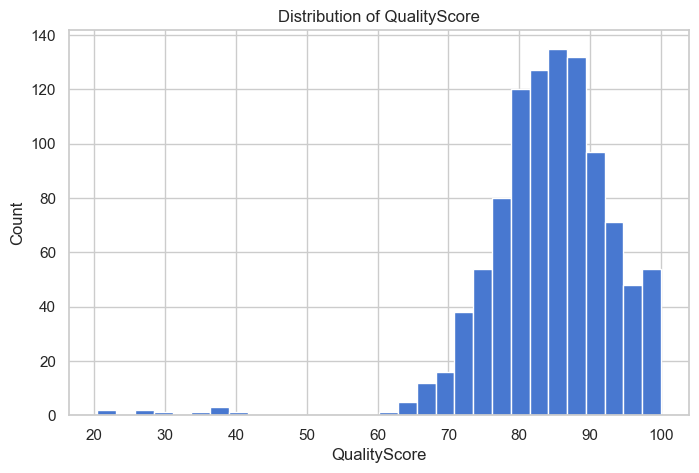

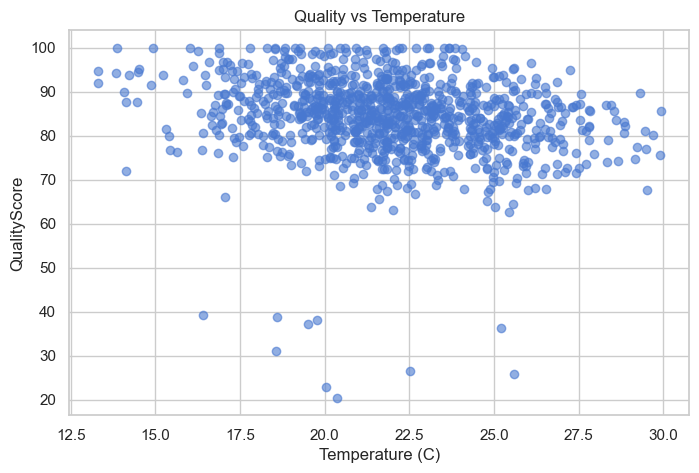

C:\Users\Angel Adaambiik\AppData\Local\Temp\ipykernel_3520\2085361814.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxes, labels=df["MachineID"].cat.categories)


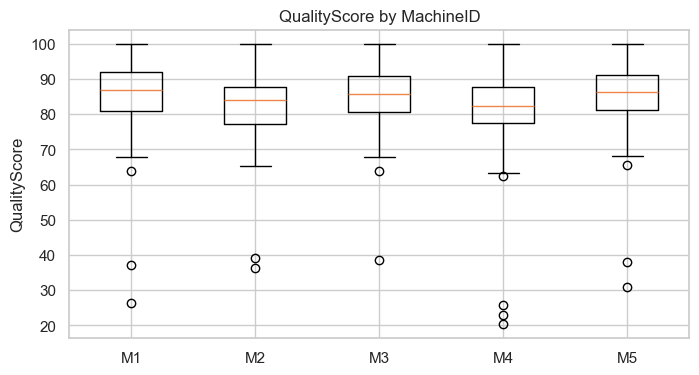

C:\Users\Angel Adaambiik\AppData\Local\Temp\ipykernel_3520\2085361814.py:28: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxes, labels=df["Shift"].cat.categories)


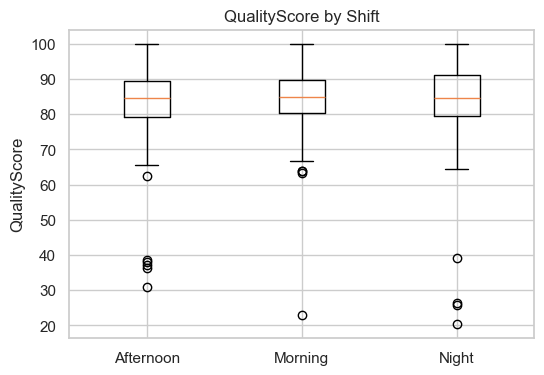

In [51]:
# CODE: histogram QualityScore
plt.figure()
plt.hist(df["QualityScore"], bins=30)
plt.title("Distribution of QualityScore")
plt.xlabel("QualityScore")
plt.ylabel("Count")
plt.show()

# CODE: scatter quality vs temperature
plt.figure()
plt.scatter(df["Temperature_C"], df["QualityScore"], alpha=0.6)
plt.xlabel("Temperature (C)")
plt.ylabel("QualityScore")
plt.title("Quality vs Temperature")
plt.show()

# CODE: boxplot of quality by MachineID (matplotlib)
plt.figure(figsize=(8,4))
boxes = [df.loc[df["MachineID"]==m, "QualityScore"] for m in df["MachineID"].cat.categories]
plt.boxplot(boxes, labels=df["MachineID"].cat.categories)
plt.title("QualityScore by MachineID")
plt.ylabel("QualityScore")
plt.show()

# CODE: quality by shift
plt.figure(figsize=(6,4))
boxes = [df.loc[df["Shift"]==s, "QualityScore"] for s in df["Shift"].cat.categories]
plt.boxplot(boxes, labels=df["Shift"].cat.categories)
plt.title("QualityScore by Shift")
plt.ylabel("QualityScore")
plt.show()


#### Correlation matrix for numeric features

QualityScore           1.000000
Pressure_kPa           0.003752
Speed_units_per_min   -0.075715
ProductionTime_min    -0.102719
Temperature_C         -0.203137
DefectCount           -0.307935
Humidity_pct          -0.412130
Name: QualityScore, dtype: float64


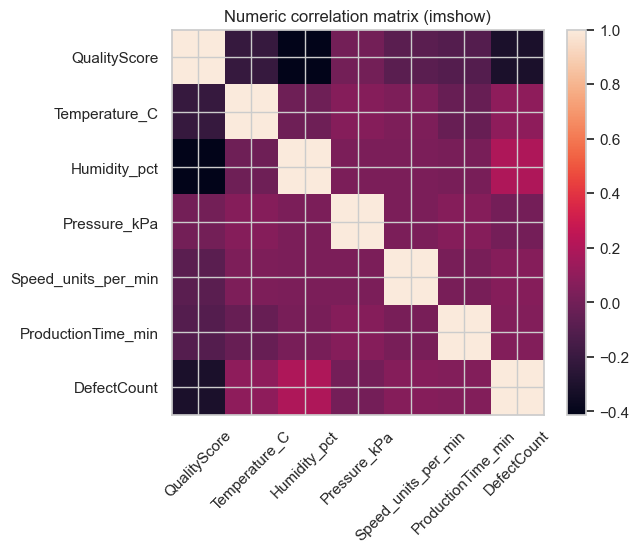

In [52]:
# CODE: correlation
num = df[["QualityScore","Temperature_C","Humidity_pct","Pressure_kPa","Speed_units_per_min","ProductionTime_min","DefectCount"]]
corr = num.corr()
print(corr["QualityScore"].sort_values(ascending=False))
# visualize correlation (imshow)
plt.figure(figsize=(6,5))
plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.index)
plt.colorbar()
plt.title("Numeric correlation matrix (imshow)")
plt.show()


#### Hypothesis tests

In [53]:
# CODE: ANOVA for MachineID
model_m = smf.ols('QualityScore ~ C(MachineID)', data=df).fit()
anova_results = anova_lm(model_m)
print("ANOVA for MachineID\n", anova_results)

# CODE: t-test Morning vs Night
g1 = df.loc[df["Shift"]=="Morning", "QualityScore"]
g2 = df.loc[df["Shift"]=="Night", "QualityScore"]
tt = stats.ttest_ind(g1, g2, equal_var=False) # Welch's t-test
print("Morning vs Night t-test (Welch):", tt)


ANOVA for MachineID
                  df        sum_sq     mean_sq         F        PR(>F)
C(MachineID)    4.0   3165.603888  791.400972  9.665768  1.137295e-07
Residual      995.0  81467.295209   81.876679       NaN           NaN
Morning vs Night t-test (Welch): TtestResult(statistic=np.float64(0.8511716217770214), pvalue=np.float64(0.3951788706279644), df=np.float64(403.496219062292))


#### Multiple Linear Regression

In [54]:
# CODE: regression with categorical variables
formula = "QualityScore ~ Temperature_C + Humidity_pct + Speed_units_per_min + ProductionTime_min + Pressure_kPa + C(MachineID) + C(Shift)"
model = smf.ols(formula, data=df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           QualityScore   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     34.42
Date:                Mon, 11 Aug 2025   Prob (F-statistic):           2.11e-62
Time:                        22:33:13   Log-Likelihood:                -3475.9
No. Observations:                1000   AIC:                             6976.
Df Residuals:                     988   BIC:                             7035.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              86.7007    

#### Check regression assumptions

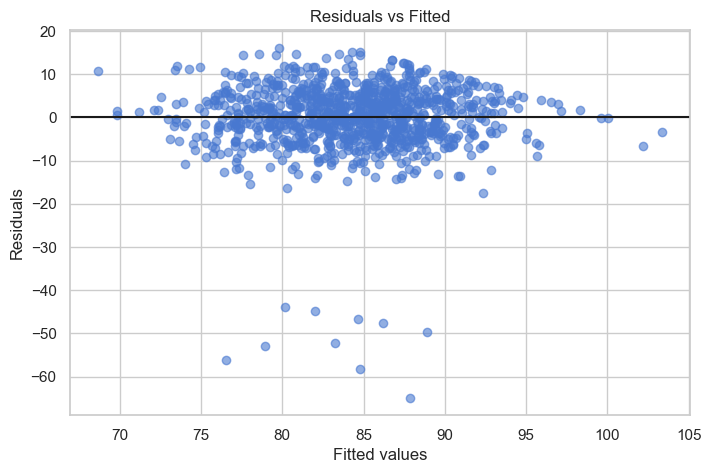

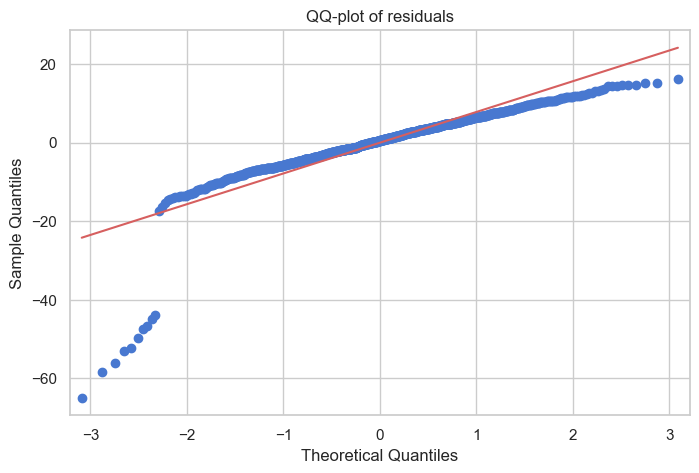

Shapiro-Wilk (resid sample): stat=0.7905 p=0.0000
Breusch-Pagan test: (np.float64(9.420770151720937), np.float64(0.5831135653464801), np.float64(0.8542037031042653), np.float64(0.5855409757597579))


In [55]:
# CODE: residuals diagnostics
resid = model.resid
fitted = model.fittedvalues

# Residual vs fitted
plt.figure()
plt.scatter(fitted, resid, alpha=0.6)
plt.axhline(0, color='k')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

# QQ-plot
sm.qqplot(resid, line='s')
plt.title("QQ-plot of residuals")
plt.show()

# Shapiro-Wilk
shap_stat, shap_p = stats.shapiro(resid.sample(500, random_state=42))  # large sample -> subsample
print("Shapiro-Wilk (resid sample): stat=%.4f p=%.4f" % (shap_stat, shap_p))

# Breusch-Pagan
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(resid, model.model.exog)
print("Breusch-Pagan test:", bp_test)  # LM stat, LM p-value, F-stat, F p-value


In [56]:
import pandas as pd
import statsmodels.api as sm

# Influence diagnostics
influence = model.get_influence()

# Standardized residuals & leverage
standard_resid = influence.resid_studentized_internal
leverage = influence.hat_matrix_diag
cooks_d = influence.cooks_distance[0]

# Put into DataFrame
diagnostics_df = pd.DataFrame({
    'Standardized Residuals': standard_resid,
    'Leverage': leverage,
    'Cooks_Distance': cooks_d
})

# Flag potential outliers: |resid| > 3 or Cook's D > 4/n
n = len(model.model.endog)
diagnostics_df['Outlier_Flag'] = (
    (diagnostics_df['Standardized Residuals'].abs() > 3) |
    (diagnostics_df['Cooks_Distance'] > (4 / n))
)

# Display potential outliers
potential_outliers = diagnostics_df[diagnostics_df['Outlier_Flag']]
print("\n--- Potential Outliers ---")
print(potential_outliers)



--- Potential Outliers ---
     Standardized Residuals  Leverage  Cooks_Distance  Outlier_Flag
229               -2.246818  0.021603        0.009289          True
268               -6.067494  0.009815        0.030408          True
377               -7.182403  0.016395        0.071657          True
380               -6.786399  0.015383        0.059963          True
398               -1.726155  0.018835        0.004766          True
466               -5.962540  0.014271        0.042893          True
472               -8.286828  0.009208        0.053184          True
492               -6.353617  0.012694        0.043251          True
521               -7.457869  0.011058        0.051826          True
528               -6.685215  0.014416        0.054474          True
547               -5.713626  0.009244        0.025381          True
570                2.062433  0.013579        0.004879          True
602               -1.751677  0.015700        0.004079          True
652               -2

#### robust inference & transformations

                            OLS Regression Results                            
Dep. Variable:           QualityScore   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     45.60
Date:                Mon, 11 Aug 2025   Prob (F-statistic):           1.64e-80
Time:                        22:40:26   Log-Likelihood:                -3475.9
No. Observations:                1000   AIC:                             6976.
Df Residuals:                     988   BIC:                             7035.
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              86.7007    

C:\Users\Angel Adaambiik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RF R2: 0.20415899215408184 RMSE: 9.790590822848738
Humidity_pct           0.318594
Temperature_C          0.205293
Speed_units_per_min    0.159632
Pressure_kPa           0.116932
ProductionTime_min     0.107956
MachineID_M4           0.023238
MachineID_M2           0.020277
Shift_Morning          0.014300
Shift_Night            0.011475
MachineID_M3           0.011447
MachineID_M5           0.010857
dtype: float64


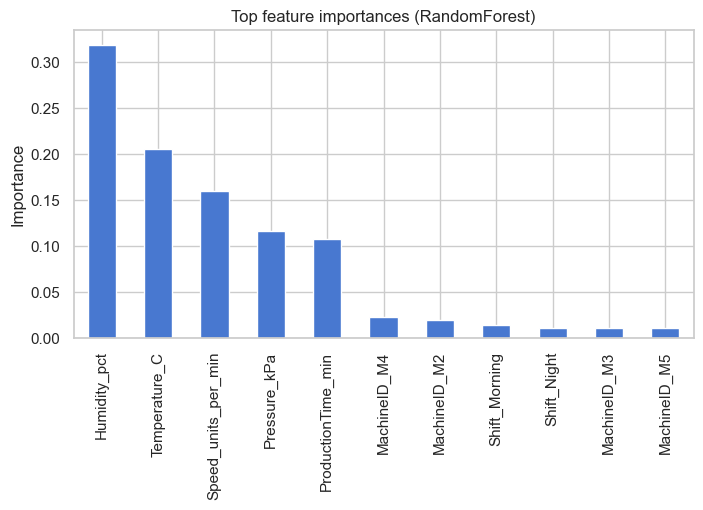

In [57]:
# CODE: robust standard errors
robust = model.get_robustcov_results(cov_type='HC3')
print(robust.summary())

# CODE: example: Random Forest to estimate feature importance
features = ["Temperature_C","Humidity_pct","Speed_units_per_min","ProductionTime_min","Pressure_kPa"]
X = pd.get_dummies(df[features + ["MachineID","Shift"]], drop_first=True)
y = df["QualityScore"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
pred = rf.predict(X_test)
print("RF R2:", r2_score(y_test, pred), "RMSE:", mean_squared_error(y_test, pred, squared=False))

# Feature importance
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(imp.head(12))
plt.figure(figsize=(8,4))
imp.head(12).plot.bar()
plt.title("Top feature importances (RandomForest)")
plt.ylabel("Importance")
plt.show()


#### Simple classification: Predict Pass/Fail

In [58]:
# CODE: coarse classification example
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

y_class = (df["QualityScore"] < 70).astype(int)  # 1 = Fail
Xc = pd.get_dummies(df[["Temperature_C","Humidity_pct","Speed_units_per_min","ProductionTime_min","Pressure_kPa","MachineID","Shift"]], drop_first=True)
X_trainc, X_testc, y_trainc, y_testc = train_test_split(Xc, y_class, random_state=42, test_size=0.25)
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_trainc, y_trainc)
print("Classification train score:", clf.score(X_trainc, y_trainc))
print("Classification test score:", clf.score(X_testc, y_testc))
feat_imp_cls = pd.Series(clf.feature_importances_, index=Xc.columns).sort_values(ascending=False)
print(feat_imp_cls.head(10))


Classification train score: 1.0
Classification test score: 0.944
Humidity_pct           0.234529
Temperature_C          0.189302
Pressure_kPa           0.169541
Speed_units_per_min    0.165370
ProductionTime_min     0.129848
MachineID_M4           0.027572
Shift_Night            0.021241
Shift_Morning          0.020916
MachineID_M5           0.018117
MachineID_M2           0.012540
dtype: float64
